# **ShopGenie**
Redifining the concept of Online shopping customer experience with agentic AI.


---

# Overview
This AI agent , **ShopGenie** , is built on langGraph and aims to provide decisive shopping experience to all people using the power of LLM.It uses tavily for web search , and llama-3.1-70B-versatile model through groq. This ai agent is made using totally open source technologies.



---

# Motivation
This AI agent is made to assist a customer to get best desired product specifically tailoured for his needs and wants. Eventhough if do not has any expertise in that particular field of whose product he wants to buy, still using the power of **ShopGenie** he could land for the best suited product for him.

---

#Key Features:
- **Tavily** for web search.
- **llama-3.1-70B** for arranging the data into specific schema and comparing products.
- Tells the best product among the searched ones.
- **Youtube API** for providing the review link of the best product for self-satisfaction.
- **SMTP** for sending mail about the best product and its review to the user.


# Important packages
following are the required packeages for this agent to function.

In [ ]:
%pip install langchain-groq langgraph tavily-python google-api-python-client langchain-community  beautifulsoup4  > /dev/null 2>&1

# Import necessary modules

In [ ]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from tavily import TavilyClient
from langchain_community.tools import TavilySearchResults
from typing import List, Optional, Dict
from typing_extensions import TypedDict
from googleapiclient.discovery import build
from google.colab import userdata
from IPython.display import Image, display
import getpass
import os
import json
import bs4
from langchain_community.document_loaders import WebBaseLoader
from pydantic import BaseModel, HttpUrl, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
import time

# Setting environment variables
These are the totally open source technologies used and environment variables which can be changed according to one's needs and availability

In [ ]:
groq_api_key = userdata.get('GROQ_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')
youtube_api_key = userdata.get('YOUTUBE_API_KEY')

#LLM being used in this notebook
llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    api_key=groq_api_key,
    temperature=0.5,
)

#Tavily for web search
tavily_client = TavilyClient(api_key=tavily_api_key)

#Youtube api for video search
youtube = build('youtube', 'v3', developerKey=youtube_api_key)

# Other Structures

In [ ]:


class SpecsComparison(BaseModel):
    processor: str = Field(..., description="Processor type and model, e.g., 'Snapdragon 888'")
    battery: str = Field(..., description="Battery capacity and type, e.g., '4500mAh'")
    camera: str = Field(..., description="Camera specs, e.g., '108MP primary'")
    display: str = Field(..., description="Display type, size, refresh rate, e.g., '6.5 inch OLED, 120Hz'")
    storage: str = Field(..., description="Storage options and expandability, e.g., '128GB, expandable'")

class RatingsComparison(BaseModel):
    overall_rating: float = Field(..., description="Overall rating out of 5, e.g., 4.5")
    performance: float = Field(..., description="Rating for performance out of 5, e.g., 4.7")
    battery_life: float = Field(..., description="Rating for battery life out of 5, e.g., 4.3")
    camera_quality: float = Field(..., description="Rating for camera quality out of 5, e.g., 4.6")
    display_quality: float = Field(..., description="Rating for display quality out of 5, e.g., 4.8")

class Comparison(BaseModel):
    product_name: str = Field(..., description="Name of the product")
    specs_comparison: SpecsComparison
    ratings_comparison: RatingsComparison
    reviews_summary: str = Field(..., description="Summary of key points from user reviews about this product")

class BestProduct(BaseModel):
    product_name: str = Field(..., description="Name of the best product")
    justification: str = Field(..., description="Explanation of why this product is the best choice")

class ProductComparison(BaseModel):
    comparisons: List[Comparison]
    best_product: BestProduct

class Highlights(BaseModel):
    Camera: Optional[str] = None
    Performance: Optional[str] = None
    Display: Optional[str] = None
    Fast_Charging: Optional[str] = None

class SmartphoneReview(BaseModel):
    """A review of a smartphone."""
    title: str = Field(..., description="The title of the smartphone review")
    url: Optional[str] = Field(None, description="The URL of the smartphone review")
    content: Optional[str] = Field(None, description="The main content of the smartphone review")
    pros: Optional[List[str]] = Field(None, description="The pros of the smartphone")
    cons: Optional[List[str]] = Field(None, description="The cons of the smartphone")
    highlights: Optional[dict] = Field(None, description="The highlights of the smartphone")
    score: Optional[float] = Field(None, description="The score of the smartphone")

class ListOfSmartphoneReviews(BaseModel):
    """A list of smartphone reviews."""
    reviews: List[SmartphoneReview] = Field(..., description="List of individual smartphone reviews")

class EmailRecommendation(BaseModel):
    subject: str = Field(..., description="The email subject line, designed to capture the recipient's attention.")
    heading: str = Field(..., description="The main heading of the email, introducing the recommended product.")
    justification_line: str = Field(..., description="A concise explanation of why the product is being recommended.")

# Main State

In [ ]:
class State(TypedDict):
    query: str
    email: str
    products: list[dict]
    product_schema: list[SmartphoneReview]
    blogs_content: Optional[List[dict]]
    best_product: dict
    comparison: list
    youtube_link: str

# Sending Email
This is a complete function of sending mail which takes ShopGenie to next level and speaks of its potential

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from google.colab import userdata

def send_email(recipient_email, subject, body):
    """Send an email dynamically using SMTP."""
    # SMTP server configuration
    smtp_server = "smtp.gmail.com"
    smtp_port = 587
    sender_email = userdata.get("GMAIL_USER")
    sender_password = userdata.get("GMAIL_PASS")

    try:
        # Create email content
        message = MIMEMultipart()
        message['From'] = sender_email
        message['To'] = recipient_email
        message['Subject'] = subject

        # Add the email body
        message.attach(MIMEText(body, 'html'))

        # Connect to the SMTP server
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()  # Start TLS encryption
            server.login(sender_email, sender_password)  # Login to the server
            server.send_message(message)  # Send the email
            print(f"Email sent successfully to {recipient_email}.")

    except Exception as e:
        print(f"Failed to send email: {e}")

In [ ]:
#Email prompt template
email_template_prompt = """
You are an expert email content writer.

Generate an email recommendation based on the following inputs:
- Product Name: {product_name}
- Justification Line: {justification_line}
- User Query: "{user_query}" (a general idea of the user's interest, such as "a smartphone for photography" or "a premium gaming laptop").

Return your output in the following JSON format:
{format_instructions}

### Input Example:
Product Name: Google Pixel 8 Pro
Justification Line: Praised for its exceptional camera, advanced AI capabilities, and vibrant display.
User Query: a phone with an amazing camera

### Example Output:
{{
  "subject": "Capture Every Moment with Google Pixel 8 Pro",
  "heading": "Discover the Power of the Ultimate Photography Smartphone",
  "justification_line": "Known for its exceptional camera quality, cutting-edge AI features, and vibrant display, the Google Pixel 8 Pro is perfect for photography enthusiasts."
}}

Now generate the email recommendation based on the inputs provided.
"""

In [ ]:
#email html template
email_html_template = """
    <html>
    <head>
        <style>
            body {{
                font-family: Arial, sans-serif;
                margin: 0;
                padding: 0;
                background-color: #f4f4f4;
            }}
            .email-container {{
                max-width: 600px;
                margin: 20px auto;
                background-color: #ffffff;
                border-radius: 8px;
                box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
                overflow: hidden;
            }}
            .header {{
                background-color: #007BFF;
                color: #ffffff;
                padding: 20px;
                text-align: center;
            }}
            .header h1 {{
                margin: 0;
                font-size: 24px;
            }}
            .content {{
                padding: 20px;
            }}
            .content h2 {{
                color: #333333;
                font-size: 20px;
                margin-bottom: 10px;
            }}
            .content p {{
                color: #555555;
                font-size: 16px;
                line-height: 1.5;
            }}
            .button {{
                display: inline-block;
                margin-top: 20px;
                background-color: #007BFF;
                color: #ffffff;
                padding: 10px 20px;
                text-decoration: none;
                border-radius: 5px;
            }}
            .footer {{
                text-align: center;
                font-size: 14px;
                color: #999999;
                padding: 10px 20px;
            }}
            .footer a {{
                color: #007BFF;
                text-decoration: none;
            }}
        </style>
    </head>
    <body>
        <div class="email-container">
            <div class="header">
                <h1>{heading}</h1>
            </div>
            <div class="content">
                <h2>Our Top Pick: {product_name}</h2>
                <p>{justification}</p>
                <p>Watch our in-depth review to explore why this phone is the best choice for you:</p>
                <a href="{youtube_link}" class="button" target="_blank">Watch the Review</a>
            </div>
            <div class="footer">
                <p>
                    Want to learn more? Visit our website or follow us for more recommendations.
                    <a href="https://www.youtube.com">Explore Now</a>
                </p>
                <p>&copy; 2024 Smartphone Recommendations, All Rights Reserved.</p>
            </div>
        </div>
    </body>
    </html>
    """

# Loading web content
This is the complete where the tavily loading all the content available on the web for that particular search

In [ ]:
# Function to load content from a specific URL
def load_blog_content(page_url):
    try:
        # Initialize WebBaseLoader with the URL
        loader = WebBaseLoader(web_paths=[page_url], bs_get_text_kwargs={"separator": " ", "strip": True})
        loaded_content = loader.load()

        # Extract full text from loaded content
        blog_content = " ".join([doc.page_content for doc in loaded_content])  # Assuming the loader returns a list of docs

        # print("Loaded Blog Content:", blog_content)
        return blog_content

    except Exception as e:
        print(f"Error loading blog content from URL {page_url}: {e}")
        return ""

# Nodes
These are node which are performing the functiond in the ShopGenie and provides it the base.

In [ ]:
#  Node function to search with Tavily and store content
def tavily_search_node(state):
    try:
        # Use the user-provided query from the state
        query = state.get('query', state['query'])
        # Perform the search with Tavily to retrieve multiple blog links
        response = tavily_client.search(query=query, max_results=1)
        if "results" not in response or not response["results"]:
            raise ValueError("No results found for the given query.")
        # Initialize an empty list to store each blog's content
        blogs_content = []
        # Iterate over the search results
        for blog in response['results']:
            blog_url = blog.get("url", "")
            if blog_url:
                # Load and store content from each URL using WebBaseLoader
                content = load_blog_content(blog_url)
                if content:
                  # Append blog details to blogs_content
                  blogs_content.append({
                      "title": blog.get("title", ""),
                      "url": blog_url,
                      "content": content,  # Use loaded content
                      "score": blog.get("score", "")
                  })

        # Store all blog contents in the state
        if len(blogs_content) > 0:

            print("Extracted Blogs Content:", blogs_content)

            return {"blogs_content":blogs_content}
        else:
            raise ValueError("No blogs content found.")

    except tavily.InvalidAPIKeyError:
        print("Error: Invalid Tavily API key. Please verify your key.")
        return {"blogs_content": []}
    except tavily.UsageLimitExceededError:
        print("Error: Tavily usage limit exceeded. Check your plan or limits.")
        return {"blogs_content": []}
    except Exception as e:
        print(f"Error with Tavily API call: {e}")
        return {"blogs_content": []}
#mapping values extarcted from web search
def schema_mapping_node(state: State):
  max_retries = 2  # Maximum number of retries
  wait_time = 60   # Wait time in seconds between retries (1 minute)
  try:
    # Check if "blogs_content" exists in the state and is not empty
    if "blogs_content" in state and state["blogs_content"]:
            # Extract blog content from the state
            blogs_content = state["blogs_content"]
            # Define the prompt
            prompt_template = """
You are a professional assistant tasked with extracting structured information from a blogs.

### Instructions:

1. **Product Details**: For each product mentioned in the blog post, populate the `products` array with structured data for each item, including:
   - `title`: The product name.
   - `url`: Link to the blog post or relevant page.
   - `content`: A concise summary of the product's main features or purpose.
   - `pros`: A list of positive aspects or advantages of the product.if available other wise extract blog content.
   - `cons`: A list of negative aspects or disadvantages.if available other wise extract blog content.
   - `highlights`: A dictionary containing notable features or specifications.if available other wise extract blog content.
   - `score`: A numerical rating score if available; otherwise, use `0.0`.

### Blogs Contents: {blogs_content}

After extracting all information, just return the response in the JSON structure given below. Do not add any extracted information. The JSON should be in a valid structure with no extra characters inside, like Python’s \n.


"""
            # Set up a parser and inject instructions into the prompt template.
            parser = JsonOutputParser(pydantic_object=ListOfSmartphoneReviews)
            # Format the prompt with the full blogs content
            prompt = PromptTemplate(
                template = prompt_template,
                input_variables = ["blogs_content"],
                partial_variables={"format_instructions": parser.get_format_instructions()}
            )
            # Retry mechanism to invoke LLM and parse the response
            for attempt in range(1, max_retries + 1):
                # try:
                    # Use LLM to process the prompt and return structured smartphone details
                    chain = prompt | llm | parser  # Invokes LLM with the prepared prompt
                    response = chain.invoke({"blogs_content": blogs_content})

                    # Check if the response contains more than one product in the schema
                    if response.get('products') and len(response['products']) > 1:
                        # If valid, store the structured schema in the state
                        return {"product_schema": response['products']}
                    else:
                        print(f"Attempt {attempt} failed: Product schema has one or fewer products.")

                    # Wait for 1 minute before retrying if not successful and retry limit not reached
                    if attempt < max_retries:
                        time.sleep(wait_time)

                # except Exception as retry_exception:
                #     print(f"Retry {attempt} error: {retry_exception}")
                #     if attempt < max_retries:
                #         time.sleep(wait_time)

            # Return an empty schema if all retries fail
            print("All retry attempts failed to create a valid product schema with more than one product.")
            return {"product_schema": []}
    else:
      # If "blogs_content" is not present or is empty, log and return state unmodified
      print("No blog content available or content is empty; schema extraction skipped.")
      return {"product_schema":[]}

  except Exception as e:
        # Error handling to catch any unexpected issues and log the error message
        print(f"Error occurred during schema extraction: {e}")
        return state
#comparing the products
def product_comparison_node(state: State):
    try:
      # Check if "product_schema" is present in the state and is not empty
      if "product_schema" in state and state["product_schema"]:
        product_schema = state["product_schema"]


        prompt_template = """
1. **List of Products for Comparison (`comparisons`):**
   - Each product should include:
     - **Product Name**: The name of the product (e.g., "Smartphone A").
     - **Specs Comparison**:
       - **Processor**: Type and model of the processor (e.g., "Snapdragon 888").
       - **Battery**: Battery capacity and type (e.g., "4500mAh").
       - **Camera**: Camera specifications (e.g., "108MP primary").
       - **Display**: Display type, size, and refresh rate (e.g., "6.5 inch OLED, 120Hz").
       - **Storage**: Storage options and whether it is expandable (e.g., "128GB, expandable").
     - **Ratings Comparison**:
       - **Overall Rating**: Overall rating out of 5 (e.g., 4.5).
       - **Performance**: Rating for performance out of 5 (e.g., 4.7).
       - **Battery Life**: Rating for battery life out of 5 (e.g., 4.3).
       - **Camera Quality**: Rating for camera quality out of 5 (e.g., 4.6).
       - **Display Quality**: Rating for display quality out of 5 (e.g., 4.8).
     - **Reviews Summary**: Summary of key points from user reviews that highlight the strengths and weaknesses of this product.

2. **Best Product Selection (`best_product`):**
   - **Product Name**: Select the best product among the compared items.
   - **Justification**: Provide a brief explanation of why this product is considered the best choice. This should be based on factors such as balanced performance, high user ratings, advanced specifications, or unique features.

---

### Example Output:

```json
{{
  "comparisons": [
    {{
      "product_name": "Smartphone A",
      "specs_comparison": {{
        "processor": "Snapdragon 888",
        "battery": "4500mAh",
        "camera": "108MP primary",
        "display": "6.5 inch OLED, 120Hz",
        "storage": "128GB, expandable"
      }},
      "ratings_comparison": {{
        "overall_rating": 4.5,
        "performance": 4.7,
        "battery_life": 4.3,
        "camera_quality": 4.6,
        "display_quality": 4.8
      }},
      "reviews_summary": "Highly rated for display quality and camera performance, with a strong processor. Battery life is good but may drain faster with heavy use."
    }},
    {{
      "product_name": "Smartphone B",
      "specs_comparison": {{
        "processor": "Apple A15 Bionic",
        "battery": "4000mAh",
        "camera": "12MP Dual",
        "display": "6.1 inch Super Retina XDR, 60Hz",
        "storage": "256GB, non-expandable"
      }},
      "ratings_comparison": {{
        "overall_rating": 4.6,
        "performance": 4.8,
        "battery_life": 4.1,
        "camera_quality": 4.5,
        "display_quality": 4.7
      }},
      "reviews_summary": "Smooth user experience with excellent performance and display. The battery is slightly smaller but generally sufficient for moderate use."
    }}
  ],
  "best_product": {{
    "product_name": "Smartphone A",
    "justification": "Chosen for its high-quality display, strong camera, and balanced performance that meets most user needs."
  }}
}}

```
Here is the product data to analyze:\n
{product_data}

"""
        parser = JsonOutputParser(pydantic_object=ProductComparison)
      # Format the prompt with the full blogs content
        prompt = PromptTemplate(
        template = prompt_template,
        input_variables = ["product_data"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
        # prompt = prompt_template.format(product_data=json.dumps(state['product_schema']))

        # Use LLM to process the prompt and return structured smartphone details
        chain = prompt | llm | parser  # Invokes LLM with the prepared prompt
        # display(response.content)
        response = chain.invoke({"product_data": json.dumps(state['product_schema'])})

        # print(response['products'])
        display(response)

        return {"comparison": response['comparisons'],"best_product":response['best_product']}


      else:
          # If "product_schema" is missing or empty, log and skip comparison logic
          print("No product schema available; product comparison skipped.")
          return state


    except Exception as e:
        print(f"Error during product comparison: {e}")
        return {"best_product": {}, "comparison_report": "Comparison failed"}
#youtube review
def youtube_review_node(state: State):
    best_product_name = state.get("best_product", {}).get("product_name")

    if not best_product_name:
        print("Skipping YouTube search: No best product found.")
        return {"youtube_link": None}

    try:
        search_response = youtube.search().list(
            q=f"{best_product_name} review",
            part="snippet",
            type="video",
            maxResults=1
        ).execute()

        video_items = search_response.get("items", [])
        if not video_items:
            print("No YouTube videos found for the best product.")
            return {"youtube_link": None}

        video_id = video_items[0]["id"]["videoId"]
        youtube_link = f"https://www.youtube.com/watch?v={video_id}"
        return {"youtube_link": youtube_link}

    except Exception as e:
        print(f"Error during YouTube search: {e}")
        return {"youtube_link": None}
#final display on the UI
def display_node(state: State):
  if "comparison" in state and state['comparison']:


      return {
        "products": state["product_schema"],
        "best_product": state["best_product"],
        "comparison": state["comparison"],
        "youtube_link": state["youtube_link"]
    }
  else:
    print("comparison not available")
#sending email
def send_email_node(state:State):
  if "best_product" in state and state['best_product']:
    user_query = state["query"]
    best_product_name = state["best_product"]["product_name"]
    justification = state["best_product"]["justification"]
    youtube_link = state["youtube_link"]
    recipient_email=state['email']
    parser = JsonOutputParser(pydantic_object=EmailRecommendation)
    prompt = PromptTemplate(
    template=email_template_prompt,
    input_variables=["product_name", "justification_line", "user_query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    chain = prompt | llm | parser
    response = chain.invoke({"product_name": best_product_name, "justification_line": justification, "user_query": user_query})
    html_content = email_html_template.format(product_name=best_product_name, justification=response["justification_line"], youtube_link=youtube_link,heading=response['heading'])
    send_email(recipient_email,subject=response['subject'],body=html_content)

# Workflow
Compiling the LangGraph workflow

In [ ]:
# Build the LangGraph
builder = StateGraph(State)
builder.add_node("tavily_search", tavily_search_node)
builder.add_node("schema_mapping", schema_mapping_node)
builder.add_node("product_comparison", product_comparison_node)
builder.add_node("youtube_review", youtube_review_node)
builder.add_node("display", display_node)
builder.add_node("send_email", send_email_node)
# Define edges to control flow between nodes
builder.add_edge(START, "tavily_search")
builder.add_edge("tavily_search", "schema_mapping")
builder.add_edge("schema_mapping", "product_comparison")
builder.add_edge("product_comparison", "youtube_review")
builder.add_edge("youtube_review", "display")
builder.add_edge("display", END)
builder.add_edge("youtube_review","send_email")
builder.add_edge("send_email",END)

# Diagram

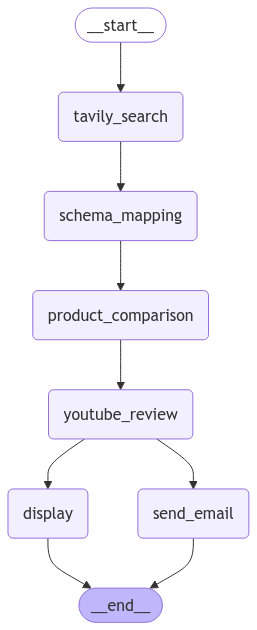

In [ ]:
# Compile and display graph as Mermaid diagram
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

# Running the Graph

In [ ]:
# Run the LangGraph workflow
initial_state = {"query": "Best smartphones under $1000","email":"asadsher2324@gmail.com"}

for event in graph.stream(input=initial_state,stream_mode="updates"):
  print(event)

Extracted Blogs Content: [{'title': 'The Best Phones Under $1000 to Buy Today - NextPit', 'url': 'https://www.nextpit.com/best-smartphones-under-1000', 'content': "The Best Phones Under $1000 to Buy Today Buying Guide Buying Guide Smartphones The best smartphones Best under $400 Best under $200 Wearables The best Bluetooth headphones to buy in 2024 Which Garmin smartwatch is the best for me? The best Apple and Android smartwatches of 2024 Deals Samsung Galaxy S22: Should you buy it now? Buying the iPhone 13? Best OnePlus 11 offer: Where to buy it! Our Favorite Bluetti AC200L Power Station is $1000 Off Apple's M2 MacBook Air with 16 GB RAM for $749 is a Must-Have Laptop Apple's Thinner Watch Series 10 Falls to a New Low for 13% Off Reviews Reviews Smartphone Samsung Galaxy S23 Ultra review Samsung Galaxy S23 review Samsung Galaxy S23+ review Apple iPhone 14 Plus review Wearables OnePlus Buds Pro 2 review Sony WH-1000XM5 review Apple Watch Ultra review Nuki Smart Lock Pro 4.0 Review: Bid

{'comparisons': [{'product_name': 'Samsung Galaxy S24',
   'specs_comparison': {'processor': 'Snapdragon 8 Gen 3 (US) / Exynos 2400 (global)',
    'battery': 'Unknown',
    'camera': 'Wide: 50 MP, f/1.8, OIS / Ultra-wide: 12 MP, f/2.2 / 3x telephoto: 10 MP, f/2.4, OIS / Selfie: 12 MP, f/2.2',
    'display': '6.2-inch',
    'storage': '128 GB UFS 3.1 storage / 256 GB UFS 4.0 storage'},
   'ratings_comparison': {'overall_rating': 4.2,
    'performance': 4.5,
    'battery_life': 3.8,
    'camera_quality': 4.5,
    'display_quality': 4.5},
   'reviews_summary': 'The Samsung Galaxy S24 has a powerful AI function, an outstanding display, and a compact design. However, it lacks a camera upgrade, has limited storage, and a shorter battery life.'},
  {'product_name': 'Apple iPhone 16',
   'specs_comparison': {'processor': 'Apple A18',
    'battery': 'Unknown',
    'camera': 'Main: 48 MP, f/1.6, OIS / Ultra-wide: 12 MP, f/2.2 / Selfie: 12 MP, f/1.9',
    'display': 'Unknown',
    'storage': '128

{'product_comparison': {'best_product': {'product_name': 'Google Pixel 8 Pro', 'justification': 'Chosen for its exceptional camera, sufficient everyday performance, and outstanding display quality. Although it has some drawbacks, its overall rating and camera quality make it the best choice among the compared products.'}, 'comparison': [{'product_name': 'Samsung Galaxy S24', 'specs_comparison': {'processor': 'Snapdragon 8 Gen 3 (US) / Exynos 2400 (global)', 'battery': 'Unknown', 'camera': 'Wide: 50 MP, f/1.8, OIS / Ultra-wide: 12 MP, f/2.2 / 3x telephoto: 10 MP, f/2.4, OIS / Selfie: 12 MP, f/2.2', 'display': '6.2-inch', 'storage': '128 GB UFS 3.1 storage / 256 GB UFS 4.0 storage'}, 'ratings_comparison': {'overall_rating': 4.2, 'performance': 4.5, 'battery_life': 3.8, 'camera_quality': 4.5, 'display_quality': 4.5}, 'reviews_summary': 'The Samsung Galaxy S24 has a powerful AI function, an outstanding display, and a compact design. However, it lacks a camera upgrade, has limited storage, 